In [93]:
import os
import tqdm
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import spatial
from scipy.optimize import curve_fit

from pi_n_xsec_net import TrainConfig, PiPlusNElectroproductionRegressor

## Load NN eval on whole ds

In [69]:
ckpt_path = "/Users/golda/Documents/Study/pi_n_xsec/basic/wandb_local_logs/pi_plus_n/pi_plus_n_layers_21_params_4974k_v1765725658/csv/version_0/checkpoints/epoch=99-step=23600.ckpt"
data_path = "../data/clasdb_pi_plus_n.txt"
device = "cuda" if torch.cuda.is_available() else "cpu"

def prepare_model_and_scaling(pipe, ckpt_path: str, device: str = device):
    """
    Returns:
        net        - torch model in eval mode
        y_mean     - float
        y_scale    - float
    """

    ckpt = torch.load(ckpt_path, map_location="cpu")
    state = ckpt["state_dict"]

    net = pipe._build_network().to(device).eval()
    net.load_state_dict(
        {k.replace("model.", "", 1): v for k, v in state.items() if k.startswith("model.")}
    )

    y_mean = float(state["y_mean"])
    y_scale = float(state["y_scale"])

    return net, y_mean, y_scale

@torch.no_grad()
def predict_from_df(df, pipe, net, y_mean: float, y_scale: float, feature_scaler, device: str = device):
    """
    df  : pd.DataFrame with FEATURE_COLUMNS
    returns np.ndarray in original units
    """
    X = df[pipe.FEATURE_COLUMNS].to_numpy(dtype=np.float32)
    Xs = feature_scaler.transform(X)

    xb = torch.tensor(Xs, dtype=torch.float32, device=device)
    pred_scaled = net(xb).squeeze(-1).cpu().numpy()
    preds_scaled_inverse = pred_scaled * y_scale + y_mean

    return preds_scaled_inverse


In [70]:
cfg = TrainConfig(data_path=data_path)
pipe = PiPlusNElectroproductionRegressor(cfg)
df = pipe.load_and_prepare_dataframe()

X = df[pipe.FEATURE_COLUMNS].to_numpy(dtype=np.float32)
pipe.feature_scaler.fit(X)
default_feature_scaler = pipe.feature_scaler

net, y_mean, y_scale = prepare_model_and_scaling(pipe=pipe, ckpt_path=ckpt_path, device=device)

df["pred_dsigma_dOmega"] = predict_from_df(df=df, pipe=pipe, net=net, y_mean=y_mean, y_scale=y_scale, feature_scaler=default_feature_scaler, device=device)

df.head()

Seed set to 1438


,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,pred_dsigma_dOmega
0,1.515,1.11,0.3,0.793353,6.021386,2.178,0.484013,0.965926,2.047820
1,1.515,1.27,0.3,-0.793353,6.021386,2.895,0.454498,0.965926,2.844567
2,1.515,1.27,0.3,-0.923880,6.021386,2.485,0.477752,0.965926,2.602558
3,1.515,1.29,0.3,-0.382683,0.261799,2.203,0.443164,0.965926,2.171553
4,1.515,1.29,0.3,-0.382683,0.785398,4.178,0.474797,0.707107,4.043813


## Generate grid

In [71]:
def generate_grid(step_W=0.005, step_Q2=0.1, step_cos_theta=0.1, step_phi=0.05):
    E_range = df.Ebeam.unique().tolist()

    data_grid = []
    for E in tqdm.tqdm(E_range):
        W_min = df[df.Ebeam==E].W.min() - 0.1
        W_max = df[df.Ebeam==E].W.max() + 0.1 + step_W

        Q2_min = df[df.Ebeam==E].Q2.min() - 0.1
        Q2_max = df[df.Ebeam==E].Q2.max() + 0.1 + step_Q2

        for W in np.arange(W_min, W_max, step_W):
            for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
                 for cos_theta in np.arange(-1, 1, step_cos_theta):
                        for phi in np.arange(0, 2*np.pi, step_phi):
                            data_grid.append([E,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    return df_grid

def generate_predictions_for_grid(df_grid, pipe, net, y_mean: float, y_scale: float):
    df_grid_parts = np.array_split(df_grid, 200)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        df_grid_part = pd.DataFrame(df_grid_part, columns=df_grid.columns)
        dsigma_dOmega_predicted = predict_from_df(df=df_grid_part, pipe=pipe, net=net, y_mean=y_mean, y_scale=y_scale, feature_scaler=default_feature_scaler, device=device)
        df_grid_part['dsigma_dOmega_predicted'] = abs(dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)
    return df_grid

In [6]:
df_grid = generate_grid()
df_grid['cos_phi'] = np.cos(df_grid.phi)

100%|██████████| 3/3 [00:16<00:00,  5.51s/it]


In [72]:
df_grid = generate_predictions_for_grid(df_grid, pipe, net, y_mean=y_mean, y_scale=y_scale)

/Users/golda/Library/Caches/pypoetry/virtualenvs/pi-n-xsec-IYDaBAFH-py3.14/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


## Build phi graphs

In [86]:
df[(df.Ebeam==5.754)&
    (df.W==1.110)&
    (df.Q2==1.715)&
    (df.cos_theta==-0.1)]

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,pred_dsigma_dOmega
2324,5.754,1.11,1.715,-0.1,0.130900,0.24835,0.08115,0.991445,0.253184
2325,5.754,1.11,1.715,-0.1,0.392699,0.31508,0.08929,0.923880,0.309444
2326,5.754,1.11,1.715,-0.1,0.654498,0.33037,0.09702,0.793353,0.370297
2327,5.754,1.11,1.715,-0.1,0.916298,0.22582,0.05960,0.608761,0.378243


In [57]:
df_grid[(df_grid.Ebeam==5.754)&
        (df_grid.W==1.110)&
        (df_grid.Q2==1.715)&
        (df_grid.cos_theta==-0.1)&
        (df_grid.phi==0.4)]

,Ebeam,W,Q2,cos_theta,phi,cos_phi,dsigma_dOmega_predicted
3425822,5.754,1.11,1.715,-0.1,0.4,0.921061,0.200875


In [91]:
def find_closest(df_for_search, W_for_search, Q2_for_search):
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, df_grid, E_beam, W, Q2, cos_theta):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W_df)&
                        (df.Q2 == Q2_df)&
                        (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')


    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("φ*π, rad", fontsize="20")
    plt.ylabel("dσ/dΩ, μb/sr", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")
    # plt.savefig(f'./final_checks/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

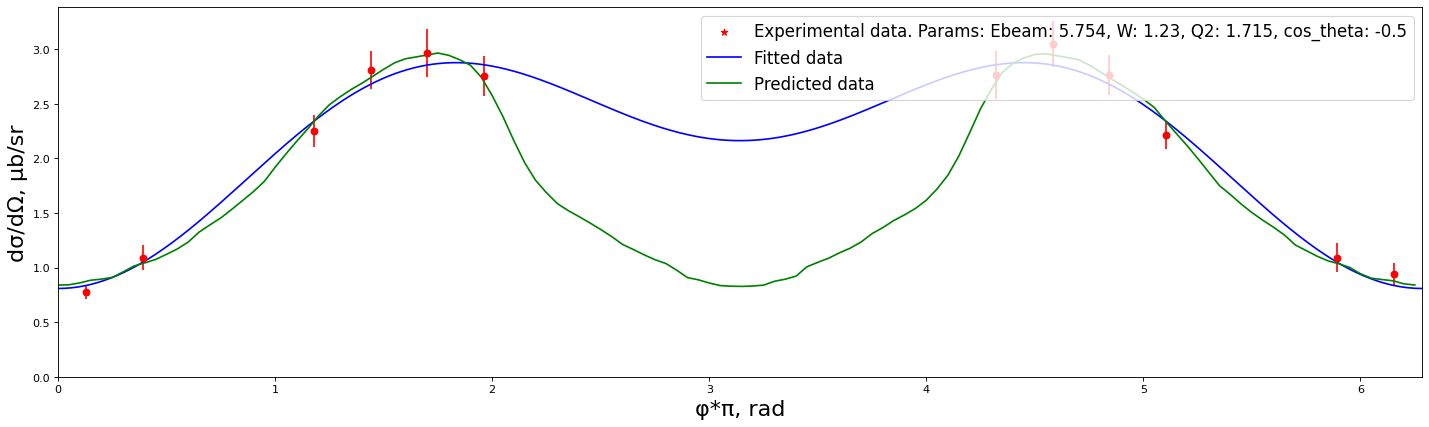

In [92]:
plot_joint_cross_sections(df, df_grid, E_beam=5.754, W=1.23, Q2=1.715, cos_theta=-0.5)

In [90]:
# for E in  tqdm.tqdm(df_grid.Ebeam.unique()):
#     for Q2 in tqdm.tqdm(df[df.Ebeam==E].Q2.unique()):
#         os.makedirs(f"./final_checks/cross_sections/E_beam={E}/Q2={Q2}")
#         for W in tqdm.tqdm([1.23, 1.53, 1.715, 1.95]):
#             os.makedirs(f"./final_checks/cross_sections/E_beam={E}/Q2={Q2}/W={W}")
#             for cos_theta in [-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
#                 try:
#                     plot_joint_cross_sections(df, E, W, Q2, cos_theta, df_grid)
#                 except:
#                     print(E, W, Q2, cos_theta)